pip install --upgrade numpy

pip install graphviz

In [1]:
import gensim
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten, TextVectorization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model, pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import activations
from sklearn.model_selection import train_test_split


2023-07-05 09:26:14.477446: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import cufflinks as cf;
# cf.go_offline()

In [3]:
wine_reviews = pd.read_csv("wine_reviews.csv")
wine_reviews.shape

(129908, 19)

In [4]:
categorical_features =  ['country','province','region_1','variety','winery','year']
numerical_features = ['price']
description_features = ['description']

In [5]:
distinct_values = wine_reviews['winery'].unique()
distinct_values.shape

(16745,)

In [6]:
wine_reviews_dl = wine_reviews[categorical_features+numerical_features+description_features+['points']]
np.where(wine_reviews_dl=='NV')
indices = np.where(wine_reviews_dl == 'NV')
wine_reviews_dl = wine_reviews_dl.drop(indices[0])
wine_reviews_dl.shape

(125280, 9)

In [7]:
from sklearn.model_selection import train_test_split
# Split the data into train and test sets
wine_reviews_X = wine_reviews_dl.drop(columns='points').head(10000)
wine_reviews_y = wine_reviews_dl['points'].head(10000)

X_train, X_test, y_train, y_test = train_test_split(wine_reviews_X, wine_reviews_y, test_size=0.2, random_state=17)

np.where(X_test=='NV')

(array([], dtype=int64), array([], dtype=int64))

## Preprocessing

In [8]:
for feature in categorical_features:
    wine_reviews_X[feature] = pd.Categorical(wine_reviews_X[feature]).codes.astype('float32')
    X_train[feature] = pd.Categorical(X_train[feature]).codes.astype('float32')
    X_test[feature] = pd.Categorical(X_test[feature]).codes.astype('float32')
    
wine_reviews_X.isnull().sum().sum()
wine_reviews_X.winery.isnull().sum().sum()



0

In [9]:
distinct_values_winery = X_train['winery'].unique()
distinct_values_variety = X_train['variety'].unique()
distinct_values_country = X_train['country'].unique()
distinct_values_year = X_train['year'].unique()


print(distinct_values_winery.shape)
print(distinct_values_variety.shape)
print(distinct_values_country.shape)
print(distinct_values_year.shape)

(4720,)
(306,)
(34,)
(28,)


In [10]:
minmax = MinMaxScaler()
wine_reviews_y = minmax.fit_transform([wine_reviews_y])

In [11]:
max_desc_len = max(wine_reviews.description_len)
max_desc_len

135

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

max_words = 1024  # Maximum number of words to consider

tokenizer_1024 = Tokenizer(num_words=1024)
tokenizer_1024.fit_on_texts(X_train.description)
desc_1024 = tokenizer_1024.texts_to_sequences(X_train.description)
max_seq_length = max(len(seq) for seq in desc_1024)




desc_1024_pad = pad_sequences(desc_1024, truncating='post', maxlen=max_seq_length)
text_input_1 = Input(shape=(max_seq_length,))

# # Split the data into training and testing sets
# X_train_text1, X_test_text1, y_train1, y_test1 = train_test_split(
#     df, y_train, test_size=0.2, random_state=42
# )
tokenizer_1024_test = Tokenizer(num_words=1024)
tokenizer_1024_test.fit_on_texts(X_test.description)
desc_1024_test = tokenizer_1024.texts_to_sequences(X_test.description)
max_seq_length_test = max(len(seq) for seq in desc_1024_test)
# df = pd.DataFrame({'winery': X_train['winery'], 'desc_1024': desc_1024_pad})
desc_1024_pad_test = pad_sequences(desc_1024_test, truncating='post', maxlen=max_seq_length)



cat_input_1 = Input(shape=(1,))
embedding_1 = Embedding(input_dim=4720, output_dim=1)(cat_input_1)
flat_embed_1 = Flatten()(embedding_1)

# Embedding layers for textual features
embedding_dim = 128
embedding_1 = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input_1)
flatten_1 = Flatten()(embedding_1)

# Concatenate flattened embeddings with dense layers for regression
concatenated = Flatten()(flatten_1)  # Remove extra Flatten layer
x = Dense(256, activation='relu')(concatenated)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='linear')(x)  # Use linear activation for continuous target variable

# Define the model
model = Model(inputs=[text_input_1], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=MeanSquaredError(),
              metrics=[MeanAbsoluteError()])

# Train the model
model.fit([desc_1024_pad], y_train,
          batch_size=32,
          epochs=10,
          validation_data=([desc_1024_pad_test], y_test))

# Evaluate the model
loss, mae = model.evaluate([desc_1024_pad_test], y_test)
print('Test Loss:', loss)
print('Test MAE:', mae)

Epoch 1/10
250/250 [==============================] - 11s 42ms/step - loss: 338.8206 - mean_absolute_error: 8.0535 - val_loss: 6.6646 - val_mean_absolute_error: 1.9557
Epoch 2/10
250/250 [==============================] - 11s 43ms/step - loss: 4.9535 - mean_absolute_error: 1.7187 - val_loss: 4.5618 - val_mean_absolute_error: 1.6675
Epoch 3/10
250/250 [==============================] - 11s 42ms/step - loss: 3.4975 - mean_absolute_error: 1.4687 - val_loss: 4.7281 - val_mean_absolute_error: 1.7206
Epoch 4/10
250/250 [==============================] - 10s 39ms/step - loss: 2.9335 - mean_absolute_error: 1.3494 - val_loss: 4.2024 - val_mean_absolute_error: 1.6005
Epoch 5/10
250/250 [==============================] - 10s 39ms/step - loss: 2.3114 - mean_absolute_error: 1.1974 - val_loss: 4.3036 - val_mean_absolute_error: 1.6162
Epoch 6/10
250/250 [==============================] - 9s 38ms/step - loss: 1.6898 - mean_absolute_error: 1.0224 - val_loss: 4.7378 - val_mean_absolute_error: 1.7041
Epo

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 1024  # Maximum number of words to consider

tokenizer_1024 = Tokenizer(num_words=1024)
tokenizer_1024.fit_on_texts(X_train.description)
desc_1024 = tokenizer_1024.texts_to_sequences(X_train.description)
max_seq_length = max(len(seq) for seq in desc_1024)

desc_1024_pad = pad_sequences(desc_1024, truncating='post', maxlen=max_seq_length)
text_input_1 = Input(shape=(max_seq_length,))

tokenizer_1024_test = Tokenizer(num_words=1024)
tokenizer_1024_test.fit_on_texts(X_test.description)
desc_1024_test = tokenizer_1024.texts_to_sequences(X_test.description)
max_seq_length_test = max(len(seq) for seq in desc_1024_test)

desc_1024_pad_test = pad_sequences(desc_1024_test, truncating='post', maxlen=max_seq_length)

cat_input_1 = Input(shape=(1,))
embedding_1 = Embedding(input_dim=4720, output_dim=16)(cat_input_1)
flat_embed_1 = Flatten()(embedding_1)

embedding_dim = 128
embedding_1_text = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input_1)
flatten_1 = Flatten()(embedding_1_text)

concatenated = Concatenate()([flatten_1, flat_embed_1])
x = Dense(256, activation='relu')(concatenated)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=[text_input_1, cat_input_1], outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=MeanSquaredError(),
              metrics=[MeanAbsoluteError()])

model.fit([desc_1024_pad, X_train['winery']], y_train,
          batch_size=32,
          epochs=10,
          validation_data=([desc_1024_pad_test, X_test['winery']], y_test))

loss, mae = model.evaluate([desc_1024_pad_test, X_test['winery']], y_test)
print('Test Loss:', loss)
print('Test MAE:', mae)

Epoch 1/10
250/250 [==============================] - 10s 38ms/step - loss: 323.0774 - mean_absolute_error: 7.9177 - val_loss: 6.6556 - val_mean_absolute_error: 1.9600
Epoch 2/10
250/250 [==============================] - 10s 39ms/step - loss: 4.5353 - mean_absolute_error: 1.6352 - val_loss: 4.7070 - val_mean_absolute_error: 1.6835
Epoch 3/10
250/250 [==============================] - 10s 39ms/step - loss: 2.5002 - mean_absolute_error: 1.2138 - val_loss: 5.5353 - val_mean_absolute_error: 1.8425
Epoch 4/10
250/250 [==============================] - 10s 38ms/step - loss: 1.6047 - mean_absolute_error: 0.9621 - val_loss: 5.8260 - val_mean_absolute_error: 1.8999
Epoch 5/10
250/250 [==============================] - 11s 43ms/step - loss: 1.0393 - mean_absolute_error: 0.7727 - val_loss: 6.0983 - val_mean_absolute_error: 1.9454
Epoch 6/10
250/250 [==============================] - 10s 39ms/step - loss: 0.7582 - mean_absolute_error: 0.6602 - val_loss: 6.5556 - val_mean_absolute_error: 2.0206
Ep

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 1024  # Maximum number of words to consider

tokenizer_1024 = Tokenizer(num_words=1024)
tokenizer_1024.fit_on_texts(X_train.description)
desc_1024 = tokenizer_1024.texts_to_sequences(X_train.description)
max_seq_length = max(len(seq) for seq in desc_1024)

desc_1024_pad = pad_sequences(desc_1024, truncating='post', maxlen=max_seq_length)
text_input_1 = Input(shape=(max_seq_length,))

tokenizer_1024_test = Tokenizer(num_words=1024)
tokenizer_1024_test.fit_on_texts(X_test.description)
desc_1024_test = tokenizer_1024.texts_to_sequences(X_test.description)
max_seq_length_test = max(len(seq) for seq in desc_1024_test)

desc_1024_pad_test = pad_sequences(desc_1024_test, truncating='post', maxlen=max_seq_length)


# winery
cat_input_1 = Input(shape=(1,))
embedding_1 = Embedding(input_dim=4720, output_dim=16)(cat_input_1)
flat_embed_1 = Flatten()(embedding_1)

#variety
cat_input_2 = Input(shape=(1,))
embedding_2 = Embedding(input_dim=306, output_dim=16)(cat_input_2)
flat_embed_2 = Flatten()(embedding_1)

#country 
cat_input_3 = Input(shape=(1,))
embedding_3 = Embedding(input_dim=34, output_dim=16)(cat_input_3)
flat_embed_3 = Flatten()(embedding_1) 


#year
cat_input_4 = Input(shape=(1,))
embedding_4 = Embedding(input_dim=28, output_dim=16)(cat_input_4)
flat_embed_4 = Flatten()(embedding_1)  

embedding_dim = 128
embedding_1_text = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input_1)
flatten_1 = Flatten()(embedding_1_text)

concatenated = Concatenate()([flatten_1, flat_embed_1,flat_embed_2,flat_embed_3])
x = Dense(256, activation='relu')(concatenated)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=[text_input_1, cat_input_1,cat_input_2,cat_input_3], outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=MeanSquaredError(),
              metrics=[MeanAbsoluteError()])

model.fit([desc_1024_pad,X_train['winery'], X_train['variety'],X_train['country']], y_train,
          batch_size=32,
          epochs=10,
          validation_data=([desc_1024_pad_test,X_test['winery'],X_test['variety'],X_test['country']], y_test))

loss, mae = model.evaluate([desc_1024_pad_test,X_test['winery'],X_test['variety'],X_test['country']], y_test)
print('Test Loss:', loss)
print('Test MAE:', mae)

Epoch 1/10
250/250 [==============================] - 13s 49ms/step - loss: 444.5528 - mean_absolute_error: 9.4792 - val_loss: 7.1512 - val_mean_absolute_error: 2.0245
Epoch 2/10
250/250 [==============================] - 12s 47ms/step - loss: 4.9068 - mean_absolute_error: 1.6982 - val_loss: 4.9824 - val_mean_absolute_error: 1.7261
Epoch 3/10
250/250 [==============================] - 12s 47ms/step - loss: 2.5793 - mean_absolute_error: 1.2296 - val_loss: 5.8082 - val_mean_absolute_error: 1.8890
Epoch 4/10
250/250 [==============================] - 11s 45ms/step - loss: 1.6173 - mean_absolute_error: 0.9533 - val_loss: 5.9549 - val_mean_absolute_error: 1.9276
Epoch 5/10
250/250 [==============================] - 11s 44ms/step - loss: 1.1879 - mean_absolute_error: 0.8060 - val_loss: 6.3742 - val_mean_absolute_error: 2.0024
Epoch 6/10
250/250 [==============================] - 11s 46ms/step - loss: 0.9256 - mean_absolute_error: 0.7145 - val_loss: 6.4972 - val_mean_absolute_error: 2.0227
Ep

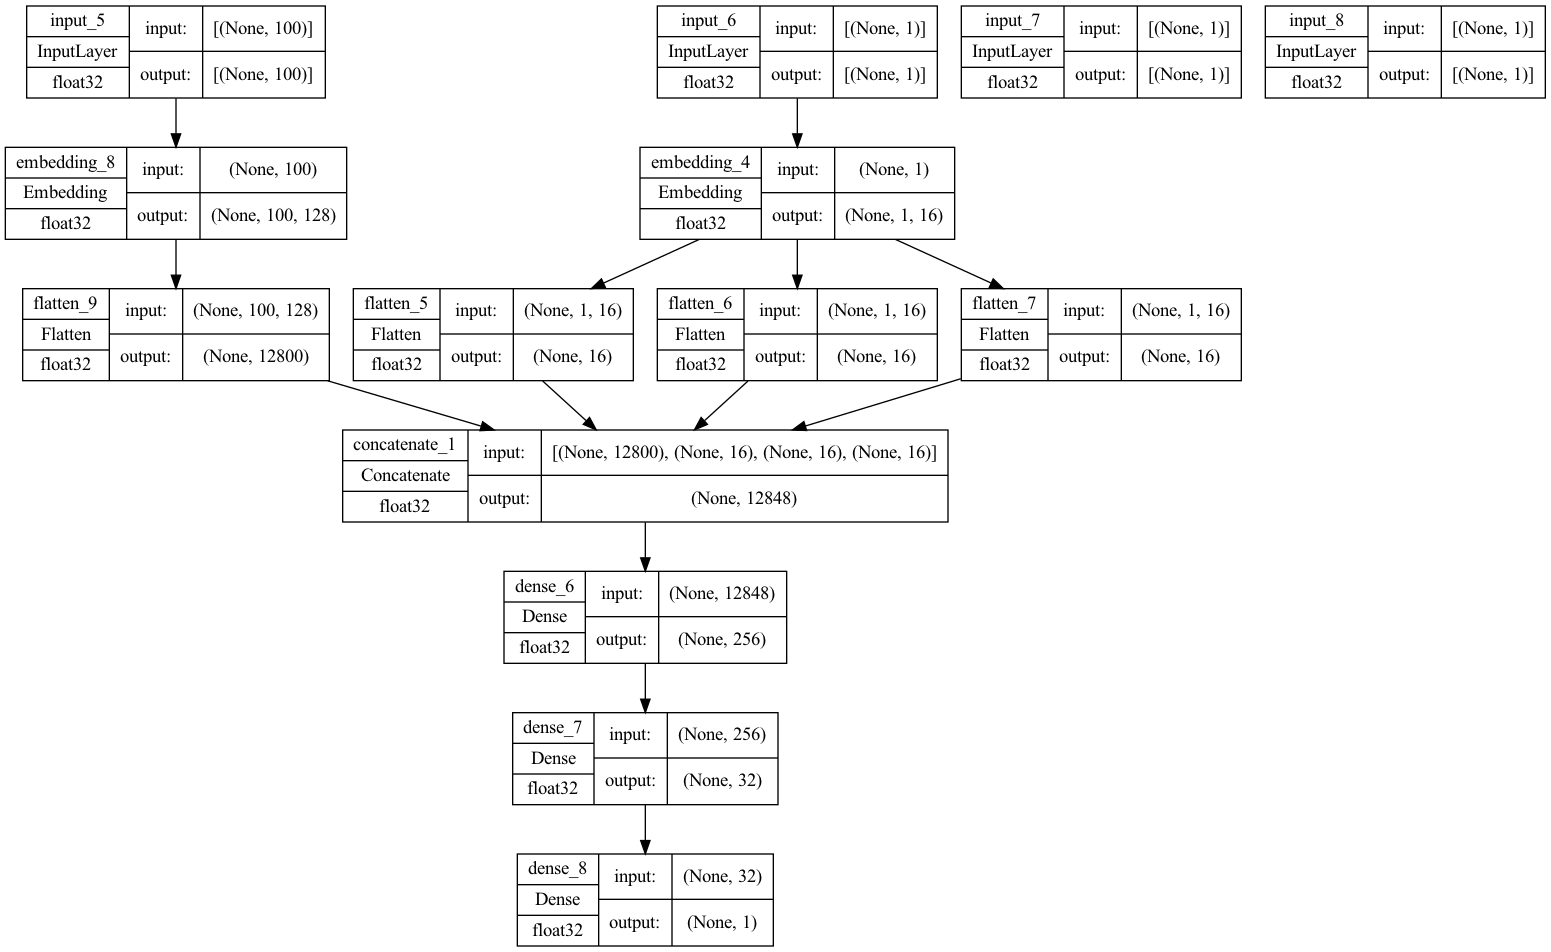

In [15]:
plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True, to_file='Images/model_1.png')

## Deep Learning - Pretrained

In [22]:
import numpy as np

embedding_dim = 300
embedding_index = {}

with open('glove.42B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [24]:
num_words = min(max_words, len(tokenizer_1024.word_index))
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in tokenizer_1024.word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 1024  # Maximum number of words to consider

tokenizer_1024 = Tokenizer(num_words=1024)
tokenizer_1024.fit_on_texts(X_train.description)
desc_1024 = tokenizer_1024.texts_to_sequences(X_train.description)
max_seq_length = max(len(seq) for seq in desc_1024)

desc_1024_pad = pad_sequences(desc_1024, truncating='post', maxlen=max_seq_length)
# text_input_1 = Input(shape=(max_seq_length,))

tokenizer_1024_test = Tokenizer(num_words=1024)
tokenizer_1024_test.fit_on_texts(X_test.description)
desc_1024_test = tokenizer_1024.texts_to_sequences(X_test.description)
max_seq_length_test = max(len(seq) for seq in desc_1024_test)

desc_1024_pad_test = pad_sequences(desc_1024_test, truncating='post', maxlen=max_seq_length)


# winery
cat_input_1 = Input(shape=(1,))
embedding_1 = Embedding(input_dim=4720, output_dim=16)(cat_input_1)
flat_embed_1 = Flatten()(embedding_1)

#variety
cat_input_2 = Input(shape=(1,))
embedding_2 = Embedding(input_dim=306, output_dim=16)(cat_input_2)
flat_embed_2 = Flatten()(embedding_1)

#country 
cat_input_3 = Input(shape=(1,))
embedding_3 = Embedding(input_dim=34, output_dim=16)(cat_input_3)
flat_embed_3 = Flatten()(embedding_1) 


#year
cat_input_4 = Input(shape=(1,))
embedding_4 = Embedding(input_dim=28, output_dim=16)(cat_input_4)
flat_embed_4 = Flatten()(embedding_1)  


text_input_1 = Input(shape=(max_seq_length,))
embedding_1_text = Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(text_input_1)
flatten_1 = Flatten()(embedding_1_text)

concatenated = Concatenate()([flatten_1, flat_embed_1,flat_embed_2,flat_embed_3])
x = Dense(256, activation='relu')(concatenated)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=[text_input_1, cat_input_1,cat_input_2,cat_input_3], outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=MeanSquaredError(),
              metrics=[MeanAbsoluteError()])

model.fit([desc_1024_pad,X_train['winery'], X_train['variety'],X_train['country']], y_train,
          batch_size=32,
          epochs=10,
          validation_data=([desc_1024_pad_test,X_test['winery'],X_test['variety'],X_test['country']], y_test))

loss, mae = model.evaluate([desc_1024_pad_test,X_test['winery'],X_test['variety'],X_test['country']], y_test)
print('Test Loss:', loss)
print('Test MAE:', mae)

Epoch 1/10
250/250 [==============================] - 24s 93ms/step - loss: 211.6806 - mean_absolute_error: 8.2711 - val_loss: 36.5744 - val_mean_absolute_error: 4.6288
Epoch 2/10
250/250 [==============================] - 22s 86ms/step - loss: 35.2511 - mean_absolute_error: 3.8356 - val_loss: 30.7223 - val_mean_absolute_error: 4.2677
Epoch 3/10
250/250 [==============================] - 22s 89ms/step - loss: 16.1839 - mean_absolute_error: 2.8020 - val_loss: 25.9878 - val_mean_absolute_error: 4.0148
Epoch 4/10
250/250 [==============================] - 25s 98ms/step - loss: 8.3553 - mean_absolute_error: 2.0312 - val_loss: 24.3984 - val_mean_absolute_error: 3.9223
Epoch 5/10
250/250 [==============================] - 25s 99ms/step - loss: 5.6647 - mean_absolute_error: 1.6331 - val_loss: 25.2572 - val_mean_absolute_error: 3.9257
Epoch 6/10
250/250 [==============================] - 25s 101ms/step - loss: 4.7352 - mean_absolute_error: 1.4204 - val_loss: 24.7544 - val_mean_absolute_error: 

#### we can see that the loss is smaller but the MAE Is bigger and this is probably because that the test of the regular training data and the test data of the same model is more similar